In [9]:
#Imports:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random

# PSO TVAC Treasure Hunt 🪙

Ovaj projekat simulira potragu za blagom pomoću **Particle Swarm Optimization (PSO)** algoritma sa **Time-Varying Acceleration Coefficients (TVAC)** pristupom.

U ovoj simulaciji, čestice predstavljaju istraživače koji pokušavaju da pronađu **blago** skriveno u velikoj numeričkoj "pustinji".  
Pustinja je predstavljena **Schwefel funkcijom**, poznatom po svom haotičnom pejzažu punom lokalnih minimuma, koji otežavaju pronalaženje pravog cilja.

---

### 🗺️ Mapa pustinje (Schwefel funkcija)

Schwefel funkcija se često koristi za testiranje optimizacionih algoritama jer sadrži **mnoštvo lokalnih minimuma** i samo **jedan globalni minimum** u tački  
`(420.9687, 420.9687)` sa vrednošću `f(x, y) = 0`.

U kontekstu igre:
- visoke vrednosti `Z` predstavljaju **brda i prepreke**,  
- niske vrednosti predstavljaju **dolinu** u kojoj se krije blago.

U sledećoj ćeliji se prikazuje 3D vizuelizacija terena koji čestice treba da istraže.


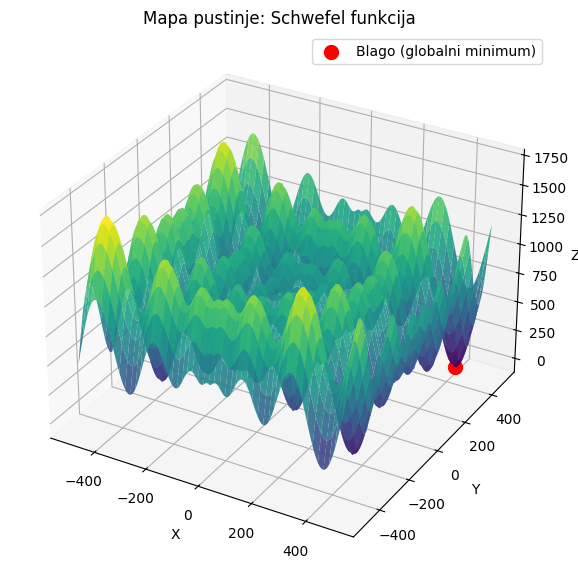

In [10]:
# Vizuelizacija "pustinje" pomoću Schwefel funkcije

def schwefel_2d(x, y):
    """
    Schwefel funkcija 2D:
    f(x, y) = 418.9829*2 - x*sin(sqrt(|x|)) - y*sin(sqrt(|y|))
    Globalni minimum: (420.9687, 420.9687), vrednost = 0
    """
    return 418.9829*2 - x*np.sin(np.sqrt(np.abs(x))) - y*np.sin(np.sqrt(np.abs(y)))

# Kreiranje mreže
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)

# 3D prikaz funkcije
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

# Obeležavanje globalnog minimuma
ax.scatter(420.9687, 420.9687, 0, color='red', s=100, label='Blago (globalni minimum)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Mapa pustinje: Schwefel funkcija')
ax.legend()
plt.show()


## Osnovni PSO algoritam

U ovoj sekciji definišemo osnovnu Particle klasu i PSO funkciju koja će iterativno pomerati čestice po mapi pustinje (Schwefel funkcija) ka globalnom minimumu.

In [11]:
class Particle:
    swarm_best_position = None
    swarm_best_value = float('inf')
    
    def __init__(self, bounds, f, c_inertia=0.5, c_social=1.0, c_cognitive=1.0):
        self.f = f
        self.bounds = bounds
        self.c_inertia = c_inertia
        self.c_social = c_social
        self.c_cognitive = c_cognitive
        
        self.position = np.random.uniform(bounds[:,0], bounds[:,1])
        self.velocity = np.random.uniform(-1, 1, size=len(bounds))
        self.value = f(*self.position)
        
        self.personal_best_position = self.position.copy()
        self.personal_best_value = self.value
        
        # ažuriramo globalni najbolji
        if Particle.swarm_best_position is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_position = self.position.copy()
            Particle.swarm_best_value = self.value
    
    def update_velocity(self):
        r_s = np.random.random(len(self.position))
        r_c = np.random.random(len(self.position))
        social = self.c_social * r_s * (Particle.swarm_best_position - self.position)
        cognitive = self.c_cognitive * r_c * (self.personal_best_position - self.position)
        self.velocity = self.c_inertia * self.velocity + social + cognitive
        
    def move(self):
        self.update_velocity()
        self.position += self.velocity
        # ostajemo unutar granica
        self.position = np.clip(self.position, self.bounds[:,0], self.bounds[:,1])
        self.value = self.f(*self.position)
        
        # ažuriramo lični i globalni najbolji
        if self.value < self.personal_best_value:
            self.personal_best_value = self.value
            self.personal_best_position = self.position.copy()
        if self.value < Particle.swarm_best_value:
            Particle.swarm_best_value = self.value
            Particle.swarm_best_position = self.position.copy()


In [12]:
def pso(f, bounds, swarm_size=20, num_iters=100, c_inertia=0.5, c_social=1.0, c_cognitive=1.0):
    swarm = [Particle(bounds, f, c_inertia, c_social, c_cognitive) for _ in range(swarm_size)]
    best_values = []
    
    for _ in range(num_iters):
        for p in swarm:
            p.move()
        best_values.append(Particle.swarm_best_value)
    
    return Particle.swarm_best_position, Particle.swarm_best_value, best_values


Najbolja pozicija: [420.96874627 420.96874697]
Vrednost na toj poziciji: 2.5455132401930314e-05


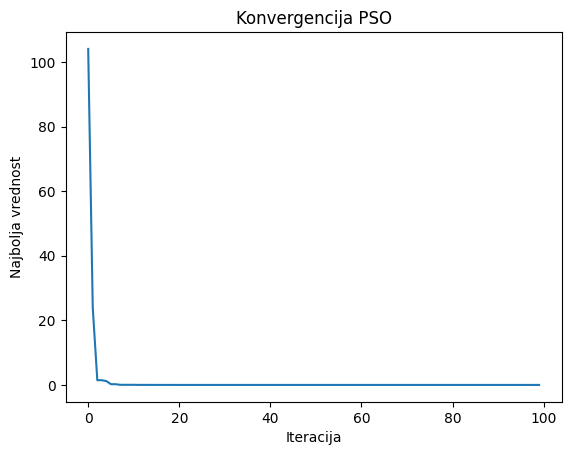

In [13]:
# Definisanje granica za 2D Schwefel
bounds = np.array([[-500, 500], [-500, 500]])

# Pokretanje PSO
best_pos, best_val, history = pso(schwefel_2d, bounds, swarm_size=30, num_iters=100)

print("Najbolja pozicija:", best_pos)
print("Vrednost na toj poziciji:", best_val)

# Grafikon konvergencije
plt.plot(history)
plt.xlabel("Iteracija")
plt.ylabel("Najbolja vrednost")
plt.title("Konvergencija PSO")
plt.show()
